# Cleaning and Analyzing Employee Exit Survey Data

## Project Summary

This project involves cleaning and analyzing data of employee exit surveys to answer the following questions from stakeholders:

* Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction?  What about employees who have been there longer?
* Are younger employees resigning due to some kind of dissatisfaction?  What about older employees?

## Data

We work with two datasets from DETE (Department of Education, Training, and Employment) and TAFE (Technical and Further Education) institute, in Queensland, Australia.  Below are descriptions of a handful of columns in the DETE survey data:

* `ID`: An id used to identify the participant of the survey
* `SeparationType`: The reason why the person's employment ended
* `Cease Date`: The year or month the person's employment ended
* `DETE Start Date`: The year the person began employment with the DETE

And below are descriptions of a few columns in the TAFE survey data:

* `Record ID`: An id used to identify the participant of the survey
* `Reason for ceasing employment`: The reason why the person's employment ended
* `LengthofServiceOverall. Overall Length of Service at Institute (in years)`: The length of the person's employment (in years)

## Results and Findings

* Redefined missing values that were originally labeled as 'Not Stated' to NaN, so that they are true null values and do not get represented in various operations on the data
    - Used the `na_values` parameter in the `pd.read_csv()` function
* Removed irrelevant columns to make the dataframes easier to work with and analyze 
    - Used the `DataFrame.drop()` method on `DataFrame.columns` attribute
* Standardized column names of both datasets in order to combine them
    - Used chained vectorized string methods (e.g. `str.strip().str.lower()`) for the DETE data
    - Used dictionary mapping as argument to the `columns` parameter of the `DataFrame.rename()` function
* Reduced datasets to include only employees that resigned since that is the interest of this project (as opposed to retired, contract termination, etc.) 
* Viewed date columns and extracted years only 
    - Used regular expression to extract year portion of MM/YYYY string format
    - Used `.value_counts()` many times to see if there are any issues
* Grouped columns that indicate employee resignation due to dissatisfaction into a single column
    - Used `.any(axis=1)` to indicate if any column contains `True` value
    - Used `.map()` to apply function to values in a column
* Combined datasets into one and removed unnecessary columns
    - Used both `.concat()` and `.dropna()` functions to do this
* Cleaned years of service values and grouped into four distinct categories (New, Experienced, Established, and Veteran)
    - Used regular expression inside `str.extract()` function to clean the values
    - Used created function inside `.apply()` that determines which of the four categories the employee belongs to
* Analyzed which tenure group is most/least likely to resign due to dissatisfaction
    - Used `.pivot_table()` to do calculation
    - Used `.plot()` to view the pivot table in a bar graph 

In [1]:
# Import libraries and read datasets
import pandas as pd
import numpy as np

dete_survey = pd.read_csv('_data/dete_survey.csv', encoding='utf-8')
tafe_survey = pd.read_csv('_data/tafe_survey.csv', encoding='utf-8')

## DETE Survey Data Exploration

We explore the DETE survey data in the following cells.

In [2]:
# View information of DETE data
dete_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   ID                                   822 non-null    int64 
 1   SeparationType                       822 non-null    object
 2   Cease Date                           822 non-null    object
 3   DETE Start Date                      822 non-null    object
 4   Role Start Date                      822 non-null    object
 5   Position                             817 non-null    object
 6   Classification                       455 non-null    object
 7   Region                               822 non-null    object
 8   Business Unit                        126 non-null    object
 9   Employment Status                    817 non-null    object
 10  Career move to public sector         822 non-null    bool  
 11  Career move to private sector        822 non-

In [3]:
# View first rows of DETE data
dete_survey.head()

,ID,SeparationType,Cease Date,DETE Start Date,Role Start Date,Position,Classification,Region,Business Unit,Employment Status,...,Kept informed,Wellness programs,Health & Safety,Gender,Age,Aboriginal,Torres Strait,South Sea,Disability,NESB
0,1,Ill Health Retirement,08/2012,1984,2004,Public Servant,A01-A04,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,Yes
1,2,Voluntary Early Retirement (VER),08/2012,Not Stated,Not Stated,Public Servant,AO5-AO7,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,NaN
2,3,Voluntary Early Retirement (VER),05/2012,2011,2011,Schools Officer,NaN,Central Office,Education Queensland,Permanent Full-time,...,N,N,N,Male,61 or older,NaN,NaN,NaN,NaN,NaN
3,4,Resignation-Other reasons,05/2012,2005,2006,Teacher,Primary,Central Queensland,NaN,Permanent Full-time,...,A,N,A,Female,36-40,NaN,NaN,NaN,NaN,NaN
4,5,Age Retirement,05/2012,1970,1989,Head of Curriculum/Head of Special Education,NaN,South East,NaN,Permanent Full-time,...,N,A,M,Female,61 or older,NaN,NaN,NaN,NaN,NaN


In [4]:
dete_survey['Cease Date'].value_counts()

2012          344
2013          200
01/2014        43
12/2013        40
Not Stated     34
09/2013        34
06/2013        27
07/2013        22
10/2013        20
11/2013        16
08/2013        12
05/2013         7
05/2012         6
04/2014         2
07/2014         2
08/2012         2
04/2013         2
02/2014         2
11/2012         1
09/2010         1
2010            1
2014            1
07/2012         1
09/2014         1
07/2006         1
Name: Cease Date, dtype: int64

## TAFE Survey Data Exploration

Next we explore the TAFE survey data.

In [5]:
# View information of TAFE data
tafe_survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 72 columns):
 #   Column                                                                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                                                                         --------------  -----  
 0   Record ID                                                                                                                                                      702 non-null    float64
 1   Institute                                                                                                                                                      702 non-null    object 
 2   WorkArea                                                                                                                                  

In [6]:
# View first rows of TAFE data
tafe_survey.head()

,Record ID,Institute,WorkArea,CESSATION YEAR,Reason for ceasing employment,Contributing Factors. Career Move - Public Sector,Contributing Factors. Career Move - Private Sector,Contributing Factors. Career Move - Self-employment,Contributing Factors. Ill Health,Contributing Factors. Maternity/Family,...,Workplace. Topic:Does your workplace promote a work culture free from all forms of unlawful discrimination?,Workplace. Topic:Does your workplace promote and practice the principles of employment equity?,Workplace. Topic:Does your workplace value the diversity of its employees?,Workplace. Topic:Would you recommend the Institute as an employer to others?,Gender. What is your Gender?,CurrentAge. Current Age,Employment Type. Employment Type,Classification. Classification,LengthofServiceOverall. Overall Length of Service at Institute (in years),LengthofServiceCurrent. Length of Service at current workplace (in years)
0,6.341330e+17,Southern Queensland Institute of TAFE,Non-Delivery (corporate),2010.0,Contract Expired,NaN,NaN,NaN,NaN,NaN,...,Yes,Yes,Yes,Yes,Female,26 30,Temporary Full-time,Administration (AO),1-2,1-2
1,6.341337e+17,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Retirement,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
2,6.341388e+17,Mount Isa Institute of TAFE,Delivery (teaching),2010.0,Retirement,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
3,6.341399e+17,Mount Isa Institute of TAFE,Non-Delivery (corporate),2010.0,Resignation,-,-,-,-,-,...,Yes,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN
4,6.341466e+17,Southern Queensland Institute of TAFE,Delivery (teaching),2010.0,Resignation,-,Career Move - Private Sector,-,-,-,...,Yes,Yes,Yes,Yes,Male,41 45,Permanent Full-time,Teacher (including LVT),3-4,3-4


## Data Cleaning and Addressing Data Issues

We redefine missing values as NaN and remove irrelevant columns in the cells below.

In [7]:
# Read in 'Not Stated' values as NaN
dete_survey = pd.read_csv('_data/dete_survey.csv', encoding='utf-8', na_values='Not Stated')

# Confirm that above worked
dete_survey['Cease Date'].value_counts()

2012       344
2013       200
01/2014     43
12/2013     40
09/2013     34
06/2013     27
07/2013     22
10/2013     20
11/2013     16
08/2013     12
05/2013      7
05/2012      6
07/2014      2
04/2014      2
08/2012      2
04/2013      2
02/2014      2
11/2012      1
09/2010      1
2010         1
2014         1
07/2012      1
09/2014      1
07/2006      1
Name: Cease Date, dtype: int64

In [8]:
# Remove irrelevant columns from each dataset
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis=1)
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis=1)

dete_survey_updated.info()
tafe_survey_updated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 822 entries, 0 to 821
Data columns (total 35 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   822 non-null    int64  
 1   SeparationType                       822 non-null    object 
 2   Cease Date                           788 non-null    object 
 3   DETE Start Date                      749 non-null    float64
 4   Role Start Date                      724 non-null    float64
 5   Position                             817 non-null    object 
 6   Classification                       455 non-null    object 
 7   Region                               717 non-null    object 
 8   Business Unit                        126 non-null    object 
 9   Employment Status                    817 non-null    object 
 10  Career move to public sector         822 non-null    bool   
 11  Career move to private sector   

## Standardizing Column Names

Next, we make some the column names consistent between both datasets in order to combine them later.

In [9]:
# Rename columns of DETE data
dete_survey_updated.columns = dete_survey_updated.columns.str.replace(' ', '_').str.strip().str.lower()

# Check that the above worked
dete_survey_updated.columns

Index(['id', 'separationtype', 'cease_date', 'dete_start_date',
       'role_start_date', 'position', 'classification', 'region',
       'business_unit', 'employment_status', 'career_move_to_public_sector',
       'career_move_to_private_sector', 'interpersonal_conflicts',
       'job_dissatisfaction', 'dissatisfaction_with_the_department',
       'physical_work_environment', 'lack_of_recognition',
       'lack_of_job_security', 'work_location', 'employment_conditions',
       'maternity/family', 'relocation', 'study/travel', 'ill_health',
       'traumatic_incident', 'work_life_balance', 'workload',
       'none_of_the_above', 'gender', 'age', 'aboriginal', 'torres_strait',
       'south_sea', 'disability', 'nesb'],
      dtype='object')

In [10]:
# Create dictionary map of old to new column names
col_renaming = {'Record ID': 'id',
               'CESSATION YEAR': 'cease_date',
               'Reason for ceasing employment': 'separationtype',
               'Gender.What is your Gender?': 'gender',
               'CurrentAge. Current Age': 'age',
               'Employment Type. Employment Type': 'employment_status',
               'Classification. Classification': 'position',
               'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service',
               'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}

# Rename columns of TAFE data
tafe_survey_updated.rename(columns=col_renaming, inplace=True)

# Check that the above worked
tafe_survey_updated.columns

Index(['id', 'Institute', 'WorkArea', 'cease_date', 'separationtype',
       'Contributing Factors. Career Move - Public Sector ',
       'Contributing Factors. Career Move - Private Sector ',
       'Contributing Factors. Career Move - Self-employment',
       'Contributing Factors. Ill Health',
       'Contributing Factors. Maternity/Family',
       'Contributing Factors. Dissatisfaction',
       'Contributing Factors. Job Dissatisfaction',
       'Contributing Factors. Interpersonal Conflict',
       'Contributing Factors. Study', 'Contributing Factors. Travel',
       'Contributing Factors. Other', 'Contributing Factors. NONE',
       'Gender. What is your Gender?', 'age', 'employment_status', 'position',
       'institute_service', 'role_service'],
      dtype='object')

Note in the output of the below two cells that there are separation types other than 'Resignation' which we are not interested in for this analysis.

In [11]:
# View frequency distribution of `separationtype` column in DETE data
dete_survey_updated['separationtype'].value_counts()

Age Retirement                          285
Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Voluntary Early Retirement (VER)         67
Ill Health Retirement                    61
Other                                    49
Contract Expired                         34
Termination                              15
Name: separationtype, dtype: int64

In [12]:
# View frequency distribution of `separationtype` column in TAFE data
tafe_survey_updated['separationtype'].value_counts()

Resignation                 340
Contract Expired            127
Retrenchment/ Redundancy    104
Retirement                   82
Transfer                     25
Termination                  23
Name: separationtype, dtype: int64

In [13]:
# Keep only data where separation type are resignations for this analysis
dete_resignations = dete_survey_updated[dete_survey_updated['separationtype'].str.contains("^Resignation")].copy()
tafe_resignations = tafe_survey_updated[tafe_survey_updated['separationtype'] == 'Resignation'].copy()

print(dete_resignations['separationtype'].value_counts())
print(tafe_resignations['separationtype'].value_counts())

Resignation-Other reasons               150
Resignation-Other employer               91
Resignation-Move overseas/interstate     70
Name: separationtype, dtype: int64
Resignation    340
Name: separationtype, dtype: int64


## Check for Inconsistencies in Date Fields

Next we check the years in each dataframe for any logical inconsistencies.

In [14]:
# Check the `cease_date` column in the DETE dataset for inconsistencies
dete_resignations["cease_date"].value_counts()

2012       126
2013        74
01/2014     22
12/2013     17
06/2013     14
09/2013     11
07/2013      9
11/2013      9
10/2013      6
08/2013      4
05/2012      2
05/2013      2
07/2012      1
2010         1
09/2010      1
07/2006      1
Name: cease_date, dtype: int64

In [15]:
# Extract only the years for `cease_date` column
dete_resignations["cease_date"] = dete_resignations["cease_date"].str.extract(r"([0-9]{4})")

# Convert the type to float
dete_resignations["cease_date"] = dete_resignations["cease_date"].astype(float)

# Check above logic worked as expected
dete_resignations["cease_date"].dtype

dtype('float64')

In [16]:
# View frequency distribution of `cease_date` column
dete_resignations["cease_date"].value_counts()

2013.0    146
2012.0    129
2014.0     22
2010.0      2
2006.0      1
Name: cease_date, dtype: int64

In [17]:
# View frequency distribution of `dete_start_date` column
dete_resignations["dete_start_date"].value_counts(ascending=False)

2011.0    24
2008.0    22
2012.0    21
2007.0    21
2010.0    17
2005.0    15
2004.0    14
2006.0    13
2009.0    13
2013.0    10
2000.0     9
1999.0     8
1994.0     6
2003.0     6
1992.0     6
1996.0     6
1998.0     6
2002.0     6
1990.0     5
1997.0     5
1980.0     5
1993.0     5
1989.0     4
1991.0     4
1988.0     4
1995.0     4
1986.0     3
2001.0     3
1985.0     3
1983.0     2
1976.0     2
1974.0     2
1975.0     1
1984.0     1
1971.0     1
1982.0     1
1972.0     1
1963.0     1
1977.0     1
1973.0     1
1987.0     1
Name: dete_start_date, dtype: int64

<AxesSubplot:>

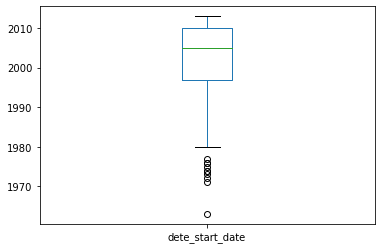

In [18]:
# Generate box plot of `dete_start_date` column
dete_resignations.boxplot(column="dete_start_date", grid=False)

In [19]:
# View frequency distribution of `cease_date` column
tafe_resignations["cease_date"].value_counts()

2011.0    116
2012.0     94
2010.0     68
2013.0     55
2009.0      2
Name: cease_date, dtype: int64

Based on the above frequency distributions of the three date columns within our resignation datasets, we found there are no major issues with the years (even though they do not span the same values).

Next we create a new (calculated) field in the `dete_resignations` dataset that represents the years of service.  This columns already exists in the `tafe_resignations` dataset and is called "service", so there is no need to do it there.

In [20]:
# Create a newly calculated field that represents employees' tenures
dete_resignations["institute_service"] = dete_resignations["cease_date"] - dete_resignations["dete_start_date"]

In [21]:
# View frequency distribution of `Contributing Factors. Dissatisfaction` column
tafe_resignations["Contributing Factors. Dissatisfaction"].value_counts(dropna=False)

-                                         277
Contributing Factors. Dissatisfaction      55
NaN                                         8
Name: Contributing Factors. Dissatisfaction, dtype: int64

In [22]:
# View frequency distribution of `Contributing Factors. Job Dissatisfaction` column
tafe_resignations["Contributing Factors. Job Dissatisfaction"].value_counts(dropna=False)

-                      270
Job Dissatisfaction     62
NaN                      8
Name: Contributing Factors. Job Dissatisfaction, dtype: int64

## Categorize Employees Reason for Resignation as Dissatisfied

We now use many of the existing columns in our datasets to group employees that resigned into one category in a newly created column named `dissatisfied`.  Doing so will make the analysis easier to perform and summarize, instead of having excessive reasons for employee resignations.

In [23]:
# Update the values in the contributing factors columns to be either True, False, or NaN
def update_vals(x):
    if x == '-':
        return False
    elif pd.isnull(x):
        return np.nan
    else:
        return True
tafe_resignations['dissatisfied'] = tafe_resignations[['Contributing Factors. Dissatisfaction', 'Contributing Factors. Job Dissatisfaction']].applymap(update_vals).any(1, skipna=False)
tafe_resignations_up = tafe_resignations.copy()

# Check the unique values after the updates
tafe_resignations_up['dissatisfied'].value_counts(dropna=False)

False    241
True      99
Name: dissatisfied, dtype: int64

In [24]:
# Create new column whose value is True if any of the specified columns are True, otherwise it is False
dete_resignations["dissatisfied"] = dete_resignations[['job_dissatisfaction',
       'dissatisfaction_with_the_department', 'physical_work_environment',
       'lack_of_recognition', 'lack_of_job_security', 'work_location',
       'employment_conditions', 'work_life_balance',
       'workload']].any(axis=1, skipna=False)

# Make copy of dataset to avoid error and view frequency distribution
dete_resignations_up = dete_resignations.copy()
dete_resignations_up['dissatisfied'].value_counts(dropna=False)

False    162
True     149
Name: dissatisfied, dtype: int64

## Combine the DETE and TAFE Datasets

In addition, we remove unnecessary columns with many null values.

In [25]:
# Before combining datasets, add column to distinguish between the two
dete_resignations_up["institute"] = "DETE"
tafe_resignations_up["institute"] = "TAFE"

# Combine datasets and check
combined = pd.concat([dete_resignations_up, tafe_resignations_up])
combined.notnull().sum().sort_values()

torres_strait                                            0
south_sea                                                3
aboriginal                                               7
disability                                               8
nesb                                                     9
business_unit                                           32
classification                                         161
region                                                 265
role_start_date                                        271
dete_start_date                                        283
Gender. What is your Gender?                           290
role_service                                           290
gender                                                 302
none_of_the_above                                      311
relocation                                             311
work_life_balance                                      311
traumatic_incident                                     3

In [26]:
# Remove columns with less than 500 non-null values
combined_updated = combined.dropna(thresh=500, axis=1)

# Check numbers of non-null values in remaining columns
combined_updated.notnull().sum().sort_values()

institute_service    563
age                  596
employment_status    597
position             598
cease_date           635
id                   651
separationtype       651
dissatisfied         651
institute            651
dtype: int64

## Clean the Years of Service Column

We also group ranges of years of service into qualitative categories (New, Experience, Established, and Veteran)

In [27]:
combined_updated["institute_service"].astype("string")
combined_updated["institute_service"].dtype

dtype('O')

In [28]:
# View unique values of `institute_service` column
combined_updated["institute_service"].value_counts()

Less than 1 year      73
1-2                   64
3-4                   63
5-6                   33
11-20                 26
5.0                   23
1.0                   22
7-10                  21
3.0                   20
0.0                   20
6.0                   17
4.0                   16
9.0                   14
2.0                   14
7.0                   13
More than 20 years    10
13.0                   8
8.0                    8
15.0                   7
20.0                   7
10.0                   6
14.0                   6
12.0                   6
17.0                   6
22.0                   6
18.0                   5
16.0                   5
11.0                   4
23.0                   4
24.0                   4
32.0                   3
39.0                   3
19.0                   3
21.0                   3
36.0                   2
25.0                   2
30.0                   2
26.0                   2
28.0                   2
49.0                   1


In [29]:
# Extract the years of service and convert the type to float
combined_updated['institute_service_up'] = combined_updated['institute_service'].astype('str').str.extract(r'(\d+)')
combined_updated['institute_service_up'] = combined_updated['institute_service_up'].astype('float')

# Check the years extracted are correct
combined_updated['institute_service_up'].value_counts()

/var/folders/78/5qnmg9f96cg9pft1yg81flk80000gn/T/ipykernel_20821/3080732130.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_updated['institute_service_up'] = combined_updated['institute_service'].astype('str').str.extract(r'(\d+)')
/var/folders/78/5qnmg9f96cg9pft1yg81flk80000gn/T/ipykernel_20821/3080732130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_updated['institute_service_up'] = combined_updated['institute_service_up'].astype('float')


1.0     159
3.0      83
5.0      56
7.0      34
11.0     30
0.0      20
20.0     17
6.0      17
4.0      16
9.0      14
2.0      14
13.0      8
8.0       8
15.0      7
17.0      6
10.0      6
22.0      6
14.0      6
12.0      6
18.0      5
16.0      5
24.0      4
23.0      4
21.0      3
19.0      3
39.0      3
32.0      3
25.0      2
28.0      2
26.0      2
36.0      2
30.0      2
34.0      1
27.0      1
29.0      1
42.0      1
33.0      1
41.0      1
35.0      1
49.0      1
38.0      1
31.0      1
Name: institute_service_up, dtype: int64

## Group Employees into Four Categories based on Years of Service (Tenure)

To more easily analyze the data, instead of viewing each employees' years of service, we create four distinct categories based on their tenures.  "New" employees have less than 3 years, "Experienced" employees have 3-6 years, "Established" employees have 6-10 years, and "Veteran" employees have 10+ years.

In [30]:
# Create function to determine category based on years of experience
def year_to_stage(yr):
    if yr < 3:
        return "New"
    elif yr <= 6:
        return "Experienced"
    elif yr <= 10:
        return "Established"
    elif yr > 10:
        return "Veteran"
    elif pd.isnull(yr):
        return np.nan

# Create new field with the above function applied to existing `institute_service_up` column
combined_updated["service_cat"] = combined_updated["institute_service_up"].apply(year_to_stage)
combined_updated["service_cat"].value_counts(dropna=False)

/var/folders/78/5qnmg9f96cg9pft1yg81flk80000gn/T/ipykernel_20821/1267221778.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_updated["service_cat"] = combined_updated["institute_service_up"].apply(year_to_stage)


New            193
Experienced    172
Veteran        136
NaN             88
Established     62
Name: service_cat, dtype: int64

In [31]:
combined_updated["dissatisfied"].value_counts(dropna=False)

False    403
True     248
Name: dissatisfied, dtype: int64

## Employee Resignation due to Dissatisfaction Percentages by Tenure

Next we summarize the data with a pivot table and bar graph of employee resignations due to dissatisfaction for each of the four tenure groups defined earlier.

In [32]:
# Create pivot table that calculates dissatisfaction percentages by service category
combined_updated_pivot = pd.pivot_table(combined_updated, index="service_cat", values="dissatisfied")

combined_updated_pivot

,dissatisfied
service_cat,
Established,0.516129
Experienced,0.343023
New,0.295337
Veteran,0.485294


<AxesSubplot:xlabel='service_cat'>

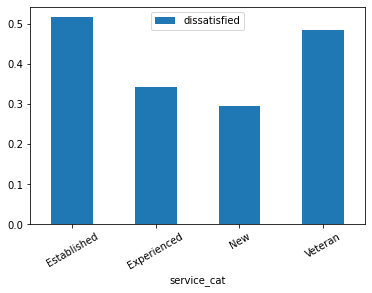

In [33]:
%matplotlib inline

# Create box plot of dissatisfaction percentages by service category
combined_updated_pivot.plot(kind='bar', rot=30)

## Summary and Results 

We can see from the bar graph above that "Established" employees (6-10 years of service) are the most likely to resign due to dissatisfaction, followed closely by "Veteran" employees (10+ years of service).  On the other hand, "New" employees (0-3 years of service) are the least likely to resign due to dissatisfaction.  "Experienced" employees (3-6 years of service) are around the middle.